## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [13]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = "./homeworks/hw01_neural_machine_translation/data.txt"
if not os.path.exists(path_do_data):
    os.makedirs("./homeworks/hw01_neural_machine_translation/")
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github.


--2023-11-07 11:11:38--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

     0K .......... .......... .......... .......... ..........  0% 2.13M 6s
    50K .......... .......... .......... .......... ..........  0% 2.85M 5s
   100K .......... .......... .......... .......... ..........  1% 10.2M 4s
   150K .......... .......... .......... .......... ..........  1% 11.2M 3s
   200K .......... .......... .......... .......... ..........  1% 4.39M 3s
   250K .......... .......... .......... .......... ..........  2% 17.2M 3s
   300K .......... .......... .......... .......... ..........  2% 20.4M 2s
   

In [2]:
import torch

torch.cuda.is_available()

False

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.data import Field, BucketIterator

# import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import utils
from utils import train, evaluate


ImportError: cannot import name 'Field' from 'torchtext.data' (/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py)

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()


def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize, init_token="<sos>", eos_token="<eos>", lower=True)

TRG = Field(tokenize=tokenize, init_token="<sos>", eos_token="<eos>", lower=True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data, format="tsv", fields=[("trg", TRG), ("src", SRC)]
)

In [7]:
# dataset, ff = dataset.split(split_ratio=0.01)

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])  # type: ignore

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")  # type: ignore
print(f"Number of validation examples: {len(valid_data.examples)}")  # type: ignore
print(f"Number of testing examples: {len(test_data.examples)}")  # type: ignore

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [10]:
SRC.build_vocab(train_data, min_freq=3)
TRG.build_vocab(train_data, min_freq=3)

In [11]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9184
Unique tokens in target (en) vocabulary: 6697


Here are tokens from original (RU) corpus:

In [12]:
SRC.vocab.itos[::10]  # ,skj 1000

['<unk>',
 'от',
 'услугам',
 'гости',
 '«',
 'плоским',
 'или',
 'отеле',
 'душем',
 'находятся',
 'оснащены',
 'зона',
 'обустроена',
 'во',
 'микроволновой',
 'кондиционер',
 'этот',
 'оформлены',
 'рестораны',
 'кафе',
 'бесплатно',
 'запросу',
 'сервируется',
 'бассейном',
 'различные',
 'де',
 'заняться',
 '300',
 'укомплектована',
 'напрокат',
 'ежедневно',
 '40',
 'торгового',
 'интернациональной',
 'время',
 'хостела',
 'игровая',
 'бассейна',
 'эти',
 'продуктов',
 'поиграть',
 'которых',
 'автомобиль',
 'стоимость',
 'ресторана',
 'гидромассажной',
 'ла',
 'кофемашиной',
 'доставка',
 'city',
 'дель',
 'велосипед',
 'блюд',
 'гладильные',
 'спальнями',
 'этаже',
 'замка',
 '19',
 'набережной',
 'клуб',
 'святого',
 'пешие',
 'ванными',
 'отведать',
 'мотель',
 'проката',
 'кроватями',
 'шезлонгами',
 'residence',
 'час',
 'разместился',
 'плавательный',
 'панорамный',
 '32',
 'плиткой',
 'бассейне',
 'человек',
 'загородный',
 'университета',
 'отдельная',
 'всем',
 'деревян

And from target (EN) corpus:

In [13]:
TRG.vocab.itos[::10]

['<unk>',
 '-',
 'away',
 'located',
 'room',
 'there',
 'flat',
 'each',
 'terrace',
 '10',
 'city',
 'hairdryer',
 'includes',
 'bath',
 'bathrooms',
 'throughout',
 '7',
 '6',
 'activities',
 'services',
 'towels',
 'storage',
 'minibar',
 'suites',
 'nearby',
 'hostel',
 '200',
 'floors',
 'wooden',
 'less',
 'water',
 'casa',
 '12',
 'upon',
 'comfortable',
 'fresh',
 'around',
 'country',
 'elegant',
 'saint',
 'play',
 'riding',
 'bicycle',
 'beaches',
 'wellness',
 'fan',
 'lobby',
 'santa',
 'court',
 'cleaning',
 'grand',
 'if',
 'box',
 'feel',
 'bicycles',
 'cold',
 'peaceful',
 'direct',
 'temple',
 '22',
 'high',
 'these',
 'opera',
 'downtown',
 'porto',
 'evening',
 'centrally',
 'communal',
 'savoury',
 'pastries',
 'opposite',
 'number',
 'courts',
 'chairs',
 'who',
 'cooking',
 'via',
 'slopes',
 'avenue',
 'dine',
 'them',
 'wines',
 'sochi',
 'machines',
 'fort',
 'ticket',
 'border',
 'sightseeing',
 'long',
 'packed',
 'hôtel',
 'sur',
 'attached',
 'clock',
 'c

And here is example from train dataset:

In [14]:
print(vars(train_data.examples[9]))

{'trg': ['certain', 'units', 'feature', 'a', 'seating', 'area', 'where', 'you', 'can', 'relax', '.'], 'src': ['в', 'некоторых', 'из', 'них', 'обустроена', 'гостиная', 'зона', '.']}


Let's check the length distributions:

Length distribution in Train data


(array([4.7500e+02, 8.6520e+03, 1.1145e+04, 8.7240e+03, 5.6170e+03,
        2.8170e+03, 1.4160e+03, 6.6900e+02, 2.7000e+02, 1.0400e+02,
        6.1000e+01, 3.0000e+01, 1.0000e+01, 5.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ,
        54.9, 59.8, 64.7, 69.6, 74.5, 79.4, 84.3, 89.2, 94.1, 99. ]),
 <BarContainer object of 20 artists>)

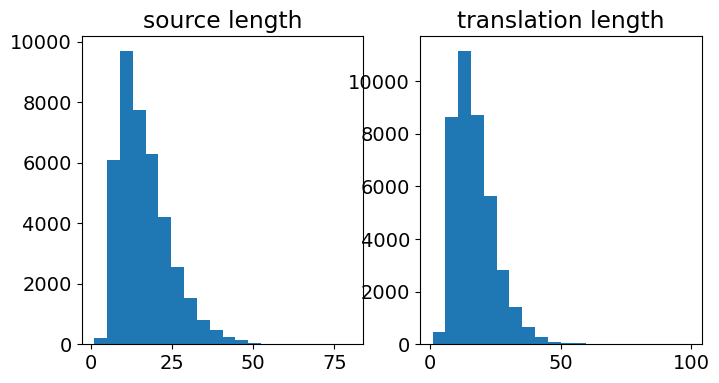

In [15]:
src_length = map(len, [vars(x)["src"] for x in train_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in train_data.examples])

print("Length distribution in Train data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

Length distribution in Test data


(array([5.380e+02, 1.592e+03, 1.726e+03, 1.356e+03, 9.630e+02, 5.980e+02,
        3.380e+02, 1.770e+02, 1.120e+02, 4.600e+01, 2.500e+01, 1.300e+01,
        1.000e+01, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 3.  ,  7.05, 11.1 , 15.15, 19.2 , 23.25, 27.3 , 31.35, 35.4 ,
        39.45, 43.5 , 47.55, 51.6 , 55.65, 59.7 , 63.75, 67.8 , 71.85,
        75.9 , 79.95, 84.  ]),
 <BarContainer object of 20 artists>)

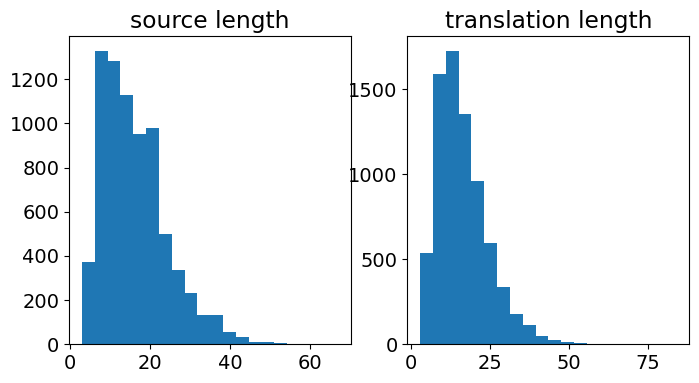

In [16]:
src_length = map(len, [vars(x)["src"] for x in test_data.examples])
trg_length = map(len, [vars(x)["trg"] for x in test_data.examples])

print("Length distribution in Test data")
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20)

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20)

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [19]:
def _len_sort_key(x):
    return len(x.src)


BATCH_SIZE = 128 // 4  # 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=_len_sort_key,
)

In [20]:
import my_network

Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [21]:
# from torchinfo import summary

# sample = next(iter(train_iterator))
# summary(model, input_data=[sample.src, sample.trg])

In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9184, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(6697, 256)
    (attention): Attention(
      (attn): Linear(in_features=512, out_features=512, bias=True)
      (softmax): Softmax(dim=0)
    )
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=1792, out_features=6697, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
print(f"The model has {utils.count_parameters(model):,} trainable parameters")

The model has 23,692,329 trainable parameters


In [24]:
PAD_IDX = TRG.vocab.stoi["<pad>"]
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [25]:
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float("inf")

In [26]:
def run(n_epochs: int, clip_size: float):
    for epoch in range(n_epochs):
        start_time = time.time()

        train_loss = train(
            model,
            train_iterator,
            optimizer,
            criterion,
            clip_size,
            train_history,
            valid_history,
        )
        valid_loss = evaluate(model, valid_iterator, criterion)

        end_time = time.time()

        epoch_mins, epoch_secs = utils.epoch_time(start_time, end_time)

        # if valid_loss < best_valid_loss:
        #     best_valid_loss = valid_loss
        # torch.save(model.state_dict(), "tut1-model.pt")

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f"Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s")
        print(
            f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}"
        )
        print(
            f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}"
        )

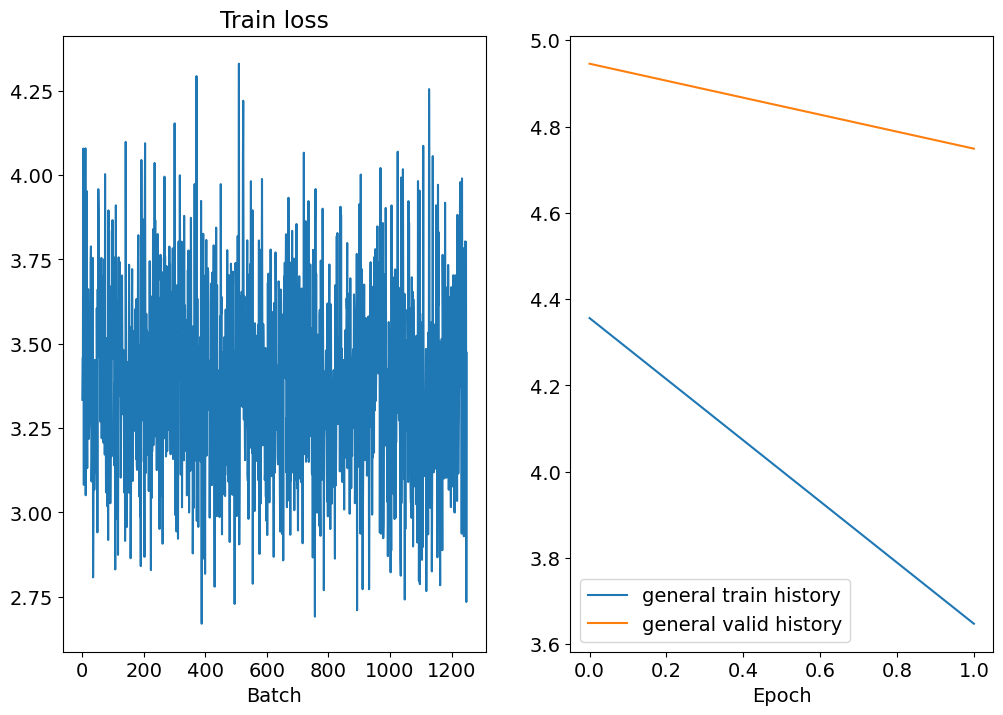

Epoch: 03 | Time: 10m 29s
	Train Loss: 3.383 | Train PPL:  29.448
	 Val. Loss: 4.688 |  Val. PPL: 108.622


In [27]:
run(N_EPOCHS, CLIP)

__Let's take a look at our network quality__:

In [28]:
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [29]:
batch = next(iter(test_iterator))

In [30]:
for idx in [1, 2]:
    src = batch.src[:, idx : idx + 1]
    trg = batch.trg[:, idx : idx + 1]
    generate_translation(src, trg, model, TRG.vocab)

Original: bed linen is featured .
Generated: bed linen is provided .

Original: the kitchen comes with an oven .
Generated: there is equipped kitchen with a microwave .



In [31]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
# translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
# return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [32]:
import tqdm

In [33]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():
    for i, batch in tqdm.tqdm(enumerate(test_iterator)):
        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0)  # turn off teacher forcing

        # trg = [trg sent len, batch size]
        # output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)

        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend(
            [get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T]
        )

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

235it [00:11, 19.67it/s]


In [34]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

8.315496097788946

Baseline solution BLEU score is quite low. Try to achieve at least __18__ BLEU on the test set. 
The checkpoints are:

* __18__ - minimal score to submit the homework, 30% of points

* __20__ - good score, 70% of points

* __25__ - excellent score, 100% of points